# fig6B

In [1]:
import scanpy as sc
import pandas as pd

# ========================
# STEP 1: Compute maximal B cell clone size per spatial bin
# ========================

# Read all samples AnnData containing celltype/clone information
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')

# Generate unique spatial bin ID: loc = batch_bin50_x_bin50_y
df = adata.obs.copy()
df['loc'] = (
    df['batch'].astype(str) + '_' +
    df['bin50_x'].astype(str) + '_' +
    df['bin50_y'].astype(str)
)

# Count the number of cells for each B cell clone (IGHcdr3aa) per bin
agg = (
    df.groupby(['loc', 'IGHcdr3aa'])
    .size()
    .astype('int32')  # Save memory
    .rename('n_cells')
    .reset_index()
)

# For each bin, retain all clones with the maximal clone size (if ties, all are kept)
idx = agg.groupby('loc')['n_cells'].idxmax()
top = agg.loc[idx]

# Save the maximal B cell clone size per bin to tsv
top.to_csv('./bin50.Bcellclonesize.tsv', index=False)

# ========================
# STEP 2: Annotate main AnnData object and summarize by annotation
# ========================

# Load integrated AnnData object containing bin/annotation data for further analysis (typically spatial bins across all LUAD samples)
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')

# Load the clone size per bin file
df_clonesize = pd.read_csv('./bin50.Bcellclonesize.tsv')

# Save original index for adata.obs, to restore after merge
original_index = adata.obs.index

# Merge maximal clone size per bin ("n_cells") annotation into adata.obs
tmp = adata.obs.merge(df_clonesize[['loc', 'n_cells']], on='loc', how='left')
tmp['n_cells'] = tmp['n_cells'].fillna(0).astype(int)
tmp.index = original_index  # Restore AnnData .obs index

# Update adata.obs with maximal B cell clone size per bin
adata.obs = tmp
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']

# Optionally, delete (if present) the previous T cell clone annotation
if 'T_clone_expansion_n_cells' in adata.obs:
    del adata.obs['T_clone_expansion_n_cells']

# ========================
# STEP 3: Summarize B clone expansion size distribution by annotation group
# ========================
for i in adata.obs['annotation'].unique():
    subset = adata[adata.obs['annotation'] == i]
    print(f"Group: {i}")
    print(subset.obs['B_clone_expansion_n_cells'].value_counts())

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Group: Tumor
0    146724
1     10571
2       207
3        22
4         5
Name: B_clone_expansion_n_cells, dtype: int64
Group: Stroma
0    22451
1     2889
2       72
3        6
4        1
Name: B_clone_expansion_n_cells, dtype: int64
Group: LA-myloid-aggregate
0    11809
1     1464
2        6
Name: B_clone_expansion_n_cells, dtype: int64
Group: LA-TLS
0    3170
1    1199
2      79
3      27
5       3
4       3
6       1
Name: B_clone_expansion_n_cells, dtype: int64
Group: LA-PCA
0    5695
1    5302
2     636
3     185
4      59
5      29
6       6
7       4
Name: B_clone_expansion_n_cells, dtype: int64
Group: Alveolar
0    38757
1     2680
2       11
Name: B_clone_expansion_n_cells, dtype: int64
Group: Ciliated
0    819
1     23
Name: B_clone_expansion_n_cells, dtype: int64


# fig6C

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


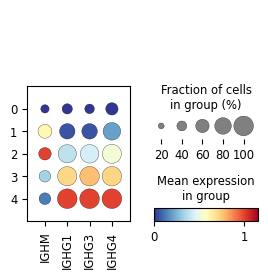

In [12]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load AnnData and the B cell clone size table
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')
df = pd.read_csv('./bin50.Bcellclonesize.tsv')
# Remove any existing T cell clone annotation, if present
if 'T_clone_expansion_n_cells' in adata.obs:
    del adata.obs['T_clone_expansion_n_cells']

# 2. Merge B cell expansion values (n_cells) into AnnData.obs using 'loc' as key
adata.obs = adata.obs.merge(
    df[['loc', 'n_cells']],
    left_on='loc',
    right_on='loc',
    how='left'
)
adata.obs.index = adata.obs.index.astype(str)  # Ensure obs index is string

# Replace missing clone values with 0
adata.obs['n_cells'] = adata.obs['n_cells'].fillna(0)

# 3. Add group column for B clone expansion and clean up
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells'].astype(int).astype(str)
adata.obs.drop(columns=['n_cells'], inplace=True)

# 4. Check selected genes exist in AnnData
genes = ['IGHM', 'IGHG1', 'IGHG3', 'IGHG4']
missing_genes = set(genes) - set(adata.var_names)
if missing_genes:
    print(f"Warning: the following genes are missing from adata.var_names: {missing_genes}")

# 5. Subset for specific annotation groups only
keep_annotations = ['Stroma','LA-PCA','LA-TLS','LA-myloid-aggregate']
adata = adata[adata.obs['annotation'].isin(keep_annotations)].copy()

# 6. Collapse all bins with expansion > 4 to '4'
def clone_size_group(x):
    try:
        val = int(x)
        return '4' if val > 4 else str(val)
    except Exception:
        return str(x)

adata.obs['clone_size_group'] = adata.obs['B_clone_expansion_n_cells'].apply(clone_size_group)

# 7. Only keep bins with group in ['0','1','2','3','4']
sel = adata.obs['clone_size_group'].isin(['0','1','2','3','4'])
adata_draw = adata[sel].copy()

# 8. Dotplot with white theme, groups by clone expansion
with plt.style.context({'axes.facecolor': 'white', 'figure.facecolor': 'white'}):
    sc.pl.dotplot(
        adata_draw,
        genes,
        standard_scale='var',
        groupby='clone_size_group',
        use_raw=False,
        cmap='RdYlBu_r',
        vmax=1.15,
        show=False
    )

    fig = plt.gcf()
    for ax in fig.axes:
        ax.set_facecolor('white')
        for text in ax.texts:
            text.set_color('black')
        ax.title.set_color('black')
        ax.xaxis.label.set_color('black')
        ax.yaxis.label.set_color('black')
        ax.tick_params(axis='x', colors='black')
        ax.tick_params(axis='y', colors='black')

    plt.savefig('fig6C_dotplot.pdf', bbox_inches='tight', facecolor='black')
    plt.show()

# fig6DF

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


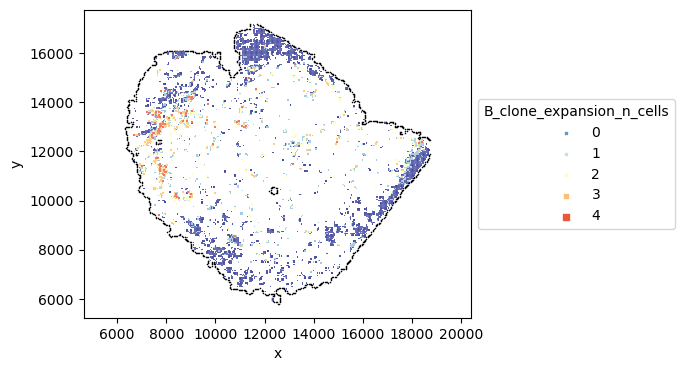

/tmp/ipykernel_611034/3223315868.py:120: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


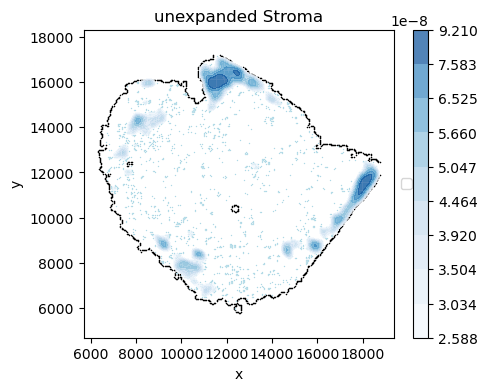

/tmp/ipykernel_611034/3223315868.py:141: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


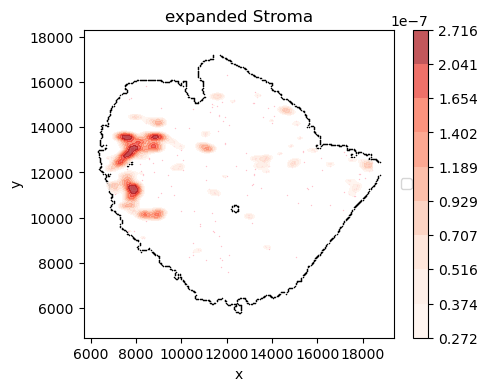

In [14]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# =========== Cell 2: Load main AnnData and clone size info ===========
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')
df = pd.read_csv('./bin50.Bcellclonesize.tsv')
original_index = adata.obs.index

# Merge clone expansion info by 'loc'
tmp_obs = adata.obs.merge(df[['loc', 'n_cells']], on='loc', how='left')
tmp_obs['n_cells'] = tmp_obs['n_cells'].fillna(0)
tmp_obs.index = original_index  # restore original AnnData index order
adata.obs = tmp_obs
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']
if 'T_clone_expansion_n_cells' in adata.obs.columns:
    del adata.obs['T_clone_expansion_n_cells']

# =========== Cell 3: Load single-sample AnnData and merge expansion info ===========
adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')
adata9.obs['loc'] = 'D06053D2_' + adata9.obs['bin50_x'].astype(str) + '_' + adata9.obs['bin50_y'].astype(str)
D06053D2 = adata[adata.obs.batch == 'D06053D2'].copy()
adata9.obs = adata9.obs.merge(
    D06053D2.obs[['loc', 'B_clone_expansion_n_cells']],
    on='loc',
    how='left'
)

# =========== Cell 4: Subset to region and build clone size groups ===========
region_list = ['Stroma', 'LA-PCA', 'LA-TLS', 'LA-myloid-aggregate']
D06053D2_stroma = D06053D2[D06053D2.obs['annotation'].isin(region_list)].copy()
D06053D2_stroma.obs['Bcellexpansion'] = 'no'
D06053D2_stroma.obs.loc[D06053D2_stroma.obs['B_clone_expansion_n_cells'].astype(float) >= 2, 'Bcellexpansion'] = 'yes'

tmp = D06053D2_stroma.obs.copy()
tmp['B_clone_expansion_n_cells'] = tmp['B_clone_expansion_n_cells'].astype(int)

def clone_size_group(x):
    try:
        val = int(x)
        return 4 if val > 4 else val
    except Exception:
        return int(x)
tmp['clone_size_group'] = tmp['B_clone_expansion_n_cells'].apply(clone_size_group)
tmp['clone_size_group'] = tmp['clone_size_group'].astype(int)

# =========== Cell 5A: Spatial scatter plot by clone size group (Figure 6D) ===========
plt.figure(figsize=(5, 4))
plt.grid(False)
# Tissue outline
tissue_outline = pd.DataFrame(adata9.uns['tissue_outline'], columns=['x', 'y'])
sns.scatterplot(data=tissue_outline, x='x', y='y', color='black', s=1, edgecolor=None)

# All bins, color by clone size group (smallest point size)
g = sns.scatterplot(
    data=tmp,
    x='x', y='y', hue='clone_size_group',
    palette='RdYlBu_r', s=1.1, marker='s'
)
# Replot 2, 3, 4 with increasing point size for emphasis
palette = sns.color_palette('RdYlBu_r', n_colors=tmp['clone_size_group'].nunique())
lut = dict(zip(sorted(tmp['clone_size_group'].unique()), palette))
for val in [2, 3, 4]:
    sns.scatterplot(
        data=tmp[tmp['clone_size_group'] == val],
        x='x', y='y',
        color=lut[val],
        s=val, marker='s', legend=False
    )

# Custom legend for clone size group
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_handles = []
for h, lab in zip(handles, labels):
    try:
        lab_int = int(lab)
        if lab_int in [2, 3, 4]:
            new_h = ax.scatter([], [], color=lut[lab_int], s=lab_int**2, marker='s', label=str(lab))
        else:
            new_h = ax.scatter([], [], color=lut[lab_int], s=1.1**2, marker='s', label=str(lab))
        new_handles.append(new_h)
    except ValueError:
        new_handles.append(h)

ax.legend(new_handles, labels,
          title='B_clone_expansion_n_cells',
          loc="center left",
          bbox_to_anchor=(1, 0.5))
plt.axis('equal')
plt.savefig('fig6D.png', dpi=600)
plt.show()

# =========== Cell 5B: Spatial KDE – unexpanded stroma (Figure 6F1) ===========
plt.figure(figsize=(5, 4))
plt.grid(False)
sns.scatterplot(data=tissue_outline, x='x', y='y', color='black', s=1, edgecolor=None)
tmp_stroma = D06053D2_stroma.obs.copy()
tmp_stroma['B_clone_expansion_n_cells'] = tmp_stroma['B_clone_expansion_n_cells'].astype(float)

sns.scatterplot(
    data=tmp_stroma[tmp_stroma['B_clone_expansion_n_cells'] < 2],
    x='x', y='y', color='lightblue', s=1
)
sns.kdeplot(
    data=tmp_stroma[tmp_stroma['B_clone_expansion_n_cells'] < 2],
    x='x', y='y', fill=True, cmap='Blues',
    bw_adjust=0.2, thresh=0.5, kernel='linear',
    cbar=True, cut=0.2, alpha=0.7
)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=3)
plt.axis('equal')
plt.title('unexpanded Stroma')
plt.savefig('fig6F1.png', dpi=900)
plt.show()

# =========== Cell 5C: Spatial KDE – expanded stroma (Figure 6F2) ===========
plt.figure(figsize=(5, 4))
plt.grid(False)
sns.scatterplot(data=tissue_outline, x='x', y='y', color='black', s=1, edgecolor=None)
sns.scatterplot(
    data=tmp_stroma[tmp_stroma['B_clone_expansion_n_cells'] >= 2],
    x='x', y='y', color='pink', s=1
)
sns.kdeplot(
    data=tmp_stroma[tmp_stroma['B_clone_expansion_n_cells'] >= 2],
    x='x', y='y', fill=True, cmap='Reds',
    bw_adjust=0.2, thresh=0.3, kernel='linear',
    cbar=True, cut=0.2, alpha=0.7
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=3)
plt.axis('equal')
plt.title('expanded Stroma')
plt.savefig('fig6F2.png', dpi=900)
plt.show()

# =========== END ===========

# fig6E

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/tmp/ipykernel_611034/3744623641.py:43: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


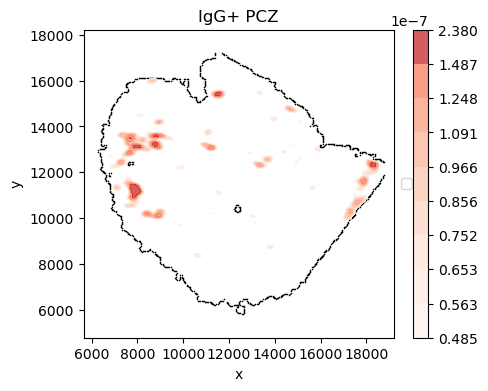

In [15]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Merge LA_anno annotation into obs of main AnnData ---
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')
meta = pd.read_csv('/data1/fengyu/methods/fig5/LA_bin50_meta.csv', index_col=0)
adata.obs['loc'] = (
    adata.obs['batch'].astype(str) + '_' +
    adata.obs['bin50_x'].astype(str) + '_' +
    adata.obs['bin50_y'].astype(str)
)
adata.obs = adata.obs.merge(meta[['loc', 'LA_anno']], on='loc', how='left')

# --- 2. Load outline from D06053D2's AnnData ---
adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')
tissue_outline = pd.DataFrame(adata9.uns['tissue_outline'], columns=['x', 'y'])

# --- 3. Filter for D06053D2 batch ---
tmp = adata.obs[adata.obs['batch'] == 'D06053D2'].copy()
tmp['LA_anno'] = tmp['LA_anno'].astype(str)

# --- 4. Plot ---
plt.figure(figsize=(5, 4))
plt.grid(False)
sns.scatterplot(data=tissue_outline, x='x', y='y', color='black', s=1, edgecolor=None)
plt.axis('equal')

# Kernel density for PCA_IGHG/A region bins (red density)
sns.kdeplot(
    data=tmp[tmp['LA_anno'] == 'PCA_IGHG/A'],
    x='x', y='y',
    fill=True,
    cmap='Reds',
    bw_adjust=0.2,
    thresh=0.5,
    kernel='linear',
    cbar=True,
    alpha=0.7
)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), markerscale=3)
plt.title('IgG+ PCZ')
plt.axis('equal')
plt.savefig('fig6E.png', dpi=600)
plt.show()

# fig6I

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


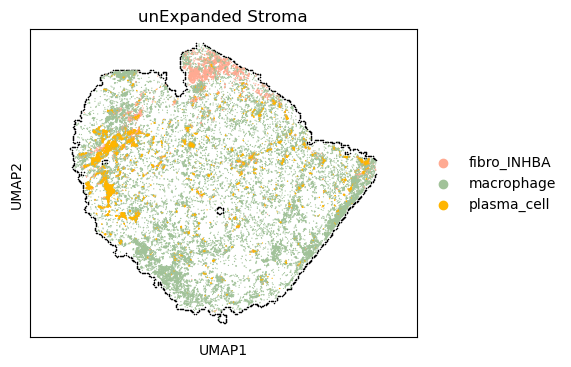

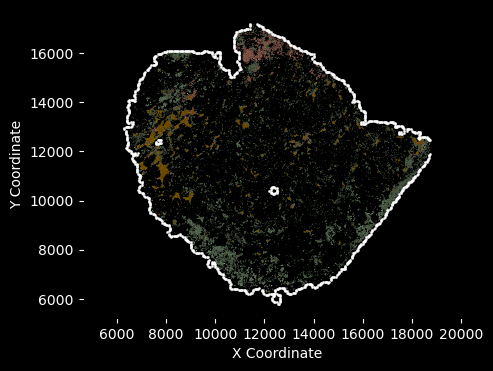

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


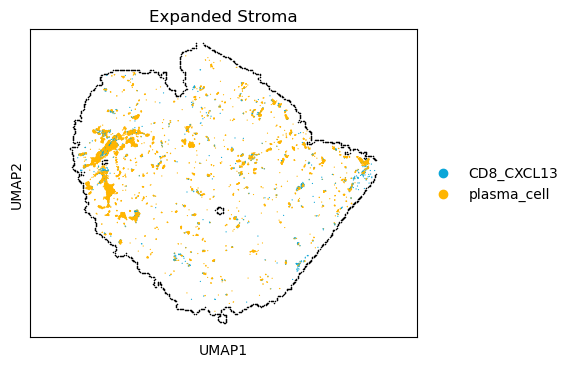

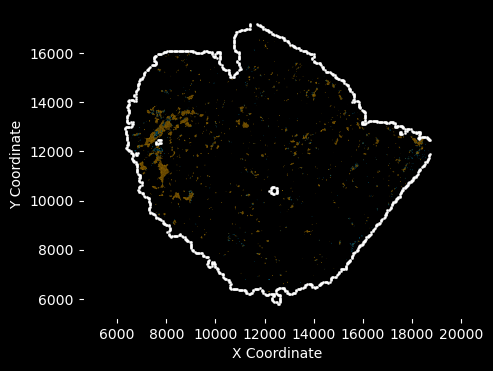

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import anndata as ad

# --- Load AnnData and subset cell types of interest ---
adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06053D2_after_preprocess_Final.h5ad')
df = adata9[adata9.obs['anno2'].isin(['fibro_INHBA','macrophage','plasma_cell'])]

fig, ax = plt.subplots(figsize=(5, 4))
plt.grid(False)

# -- Draw tissue outline in black --
tissue_outline = pd.DataFrame(adata9.uns['tissue_outline'], columns=['x', 'y'])
sns.scatterplot(
    data=tissue_outline,
    x='x', y='y',
    color='black', s=1, edgecolor=None, ax=ax
)
plt.axis('equal')
# Save current x, y limits to fix aspect ratio
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# -- Draw UMAP on same axes, do not show immediately --
sc.pl.umap(
    df,
    color='anno2',
    groups=['fibro_INHBA', 'macrophage', 'plasma_cell'],
    palette={
        'fibro_INHBA': '#FFAA92',
        'macrophage': '#A1C299',
        'plasma_cell': '#FFB500'
    },
    s=3,
    ax=ax,
    show=False
)

# Restore original x/y limits to maintain equal aspect
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.axis('equal')
plt.title('unExpanded Stroma')
plt.show()

# === Patch plot #1: fibro_INHBA, macrophage, plasma_cell ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from scipy.interpolate import splprep, splev
import seaborn as sns

# 1. Unfold the cell_border array to DataFrame
array_2d = adata9.obsm['cell_border'].reshape(-1, adata9.obsm['cell_border'].shape[-1])
df = pd.DataFrame(array_2d)
df['cellID'] = df.index // 32
df['cellID'] = df['cellID'].astype(int)
df.rename(columns={0: 'x', 1: 'y'}, inplace=True)

# 2. Filter out invalid border points
df_filtered = df[(df['x'] != 32767) & (df['y'] != 32767)]

# 3. Merge with original position (ensure correct sum/choice if your coordinates are absolute or relative)
df_filtered = pd.merge(df_filtered, adata9.obs[['x', 'y', 'cellID']], on='cellID', how='left')
df_filtered['x'] = df_filtered['x_x'] + df_filtered['x_y']
df_filtered['y'] = df_filtered['y_x'] + df_filtered['y_y']
df_cellborder = df_filtered[['cellID', 'x', 'y']]

# 4. Keep only cells of interest
cell_list = adata9.obs['cellID'].astype(int).tolist()
df_cellborder = df_cellborder[df_cellborder['cellID'].isin(cell_list)]

# 5. Group cell IDs by cell type
plasma_list = adata9.obs[adata9.obs['anno2'] == 'plasma_cell']['cellID'].astype(int).tolist()
macrophage_list = adata9.obs[adata9.obs['anno2'] == 'macrophage']['cellID'].astype(int).tolist()
fibro_INHBA_list = adata9.obs[adata9.obs['anno2'] == 'fibro_INHBA']['cellID'].astype(int).tolist()

# 6. Build border df per cell type
plasma_cell_border = df_cellborder[df_cellborder['cellID'].isin(plasma_list)]
macrophage_cell_border = df_cellborder[df_cellborder['cellID'].isin(macrophage_list)]
fibro_cell_border = df_cellborder[df_cellborder['cellID'].isin(fibro_INHBA_list)]

# 7. Extract borders as arrays for each cell
def border_list_from_df(cell_border_df):
    return [np.array(group[['x', 'y']].values) for _, group in cell_border_df.groupby('cellID') if len(group) >= 3]

filtered_cell_borders_list1 = border_list_from_df(plasma_cell_border)
filtered_cell_borders_list2 = border_list_from_df(macrophage_cell_border)
filtered_cell_borders_list3 = border_list_from_df(fibro_cell_border)

# 8. Color and background configuration
plasma_color = '#FFB500'
macro_color = '#A1C299'
fibro_color = '#FFAA92'
BG_COLOR = 'black'
TXT_COLOR = 'white'

fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

# 9. Smooth borders, generate PathPatch for each cell
def smooth_boundary(boundary, smoothness=0.5):
    x = boundary[:, 0]
    y = boundary[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    tck, u = splprep([x, y], s=smoothness * len(x), per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))

patches = []
for cell_boundary in filtered_cell_borders_list1:
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             facecolor=plasma_color,
                             lw=0.05,
                             antialiased=True))
for cell_boundary in filtered_cell_borders_list2:
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             facecolor=macro_color,
                             lw=0.05,
                             antialiased=True))
for cell_boundary in filtered_cell_borders_list3:
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             facecolor=fibro_color,
                             lw=0.05,
                             antialiased=True))

ax.add_collection(PatchCollection(patches, match_original=True))

# 10. Draw tissue outline in white
sns.scatterplot(data=tissue_outline, x='x', y='y',
                color='white', s=3, edgecolor=None, ax=ax)

# 11. Beautify and save
ax.set_xlabel("X Coordinate", color=TXT_COLOR)
ax.set_ylabel("Y Coordinate", color=TXT_COLOR)
ax.tick_params(axis='both', colors=TXT_COLOR)
ax.grid(False)
plt.axis('equal')

plt.show()

# === Repeat for patch and UMAP for CD8_CXCL13, plasma_cell ===

df = adata9[adata9.obs['anno2'].isin(['CD8_CXCL13','plasma_cell'])]

fig, ax = plt.subplots(figsize=(5, 4))
plt.grid(False)
tissue_outline = pd.DataFrame(adata9.uns['tissue_outline'], columns=['x', 'y'])
plt.axis('equal')
sns.scatterplot(data=tissue_outline, x='x', y='y', color='black', s=1, edgecolor=None, ax=ax)
sc.pl.umap(df, color=['anno2'],
           groups=['CD8_CXCL13', 'plasma_cell'],
           palette={
               'CD8_CXCL13': '#0AA6D8',
               'plasma_cell': '#FFB500'
           },
           s=3, ax=ax, show=False)
# Restore axis limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.axis('equal')
plt.title('Expanded Stroma')
plt.show()

# Patch plot: CD8_CXCL13 and plasma_cell
# 1. Unfold cell_border array
array_2d = adata9.obsm['cell_border'].reshape(-1, adata9.obsm['cell_border'].shape[-1])
df = pd.DataFrame(array_2d)
df['cellID'] = df.index // 32
df['cellID'] = df['cellID'].astype(int)
df.rename(columns={0: 'x', 1: 'y'}, inplace=True)

# 2. Remove invalid border points
df_filtered = df[(df['x'] != 32767) & (df['y'] != 32767)]

# 3. Merge with original cell positions
df_filtered = pd.merge(df_filtered, adata9.obs[['x', 'y', 'cellID']], on='cellID', how='left')
df_filtered['x'] = df_filtered['x_x'] + df_filtered['x_y']
df_filtered['y'] = df_filtered['y_x'] + df_filtered['y_y']
df_cellborder = df_filtered[['cellID', 'x', 'y']]

# 4. Keep only cells of interest
cell_list = adata9.obs['cellID'].astype(int).tolist()
df_cellborder = df_cellborder[df_cellborder['cellID'].isin(cell_list)]

# 5. Group cell IDs
plasma_list = adata9.obs[adata9.obs['anno2'] == 'plasma_cell']['cellID'].astype(int).tolist()
CD8_CXCL13_list = adata9.obs[adata9.obs['anno2'] == 'CD8_CXCL13']['cellID'].astype(int).tolist()

# 6. Build cell border df
plasma_cell_border = df_cellborder[df_cellborder['cellID'].isin(plasma_list)]
CD8_CXCL13_cell_border = df_cellborder[df_cellborder['cellID'].isin(CD8_CXCL13_list)]

# 7. Get borders per cell
def border_list_from_df(cell_border_df):
    return [np.array(group[['x', 'y']].values) for _, group in cell_border_df.groupby('cellID') if len(group) >= 3]

filtered_cell_borders_list1 = border_list_from_df(plasma_cell_border)
filtered_cell_borders_list2 = border_list_from_df(CD8_CXCL13_cell_border)

# 8. Colors
plasma_color = '#FFB500'
CD8_color = '#0AA6D8'
BG_COLOR = 'black'
TXT_COLOR = 'white'

fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

def smooth_boundary(boundary, smoothness=0.5):
    x = boundary[:, 0]
    y = boundary[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    tck, u = splprep([x, y], s=smoothness * len(x), per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))

patches = []
for cell_boundary in filtered_cell_borders_list1:
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             facecolor=plasma_color,
                             lw=0.05,
                             antialiased=True))
for cell_boundary in filtered_cell_borders_list2:
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             facecolor=CD8_color,
                             lw=0.05,
                             antialiased=True))

ax.add_collection(PatchCollection(patches, match_original=True))

# 10. Draw tissue outline in white
sns.scatterplot(data=tissue_outline, x='x', y='y',
                color='white', s=3, edgecolor=None, ax=ax)

# 11. Beautify and save
ax.set_xlabel("X Coordinate", color=TXT_COLOR)
ax.set_ylabel("Y Coordinate", color=TXT_COLOR)
ax.tick_params(axis='both', colors=TXT_COLOR)
ax.grid(False)
plt.axis('equal')

plt.show()

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


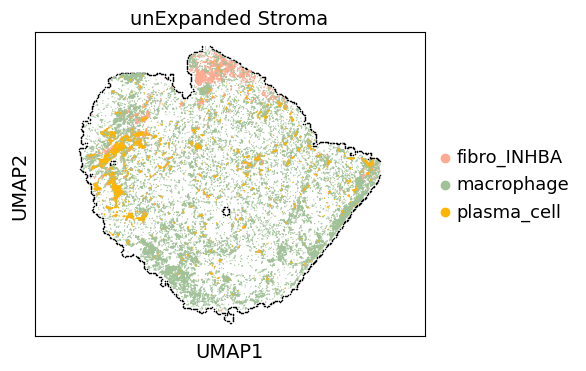

In [18]:
#import gseapy as gp
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import omicverse as ov
#import scvelo as scv
import anndata as ad
#from pyslingshot import Slingshot

adata9 = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/D06053D2/test_analysis_celltype/04.D06050D2_after_preprocess_Final.h5ad')

df = adata9[adata9.obs['anno2'].isin(['fibro_INHBA','macrophage','plasma_cell'])]

fig, ax = plt.subplots(figsize=(5, 4))
plt.grid(False)

# 画 tissue outline
tissue_outline = pd.DataFrame(adata9.uns['tissue_outline'], columns=['x', 'y'])
sns.scatterplot(
    data=tissue_outline,
    x='x', y='y',
    color='black', s=1, edgecolor=None, ax=ax
)
plt.axis('equal')
# 保存当前的x、y范围
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 画 UMAP，不show，画在 ax 上
sc.pl.umap(
    df,
    color='anno2',
    groups=['fibro_INHBA', 'macrophage', 'plasma_cell'],
    palette={
        'fibro_INHBA': '#FFAA92',
        'macrophage': '#A1C299',
        'plasma_cell': '#FFB500'
    },
    s=3,
    ax=ax,
    show=False
)

# 恢复原来的坐标范围，保证 outline 的比例不变
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.axis('equal')
plt.title('unExpanded Stroma')
plt.savefig('figure6I1.png',dpi = 900)
plt.show()

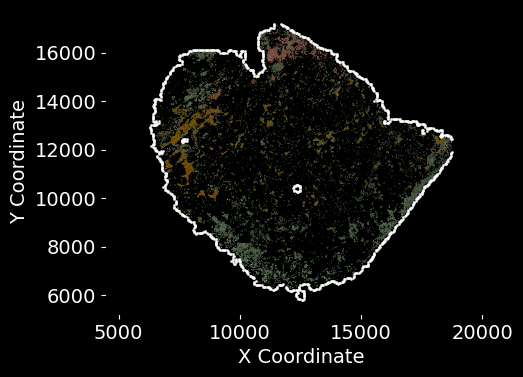

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from scipy.interpolate import splprep, splev
import seaborn as sns

# 1. 处理 cell_border 数组，展开为 DataFrame
array_2d = adata9.obsm['cell_border'].reshape(-1, adata9.obsm['cell_border'].shape[-1])
df = pd.DataFrame(array_2d)
df['cellID'] = df.index // 32
df['cellID'] = df['cellID'].astype(int)
df.rename(columns={0: 'x', 1: 'y'}, inplace=True)

# 2. 去除无效边界点
df_filtered = df[(df['x'] != 32767) & (df['y'] != 32767)]

# 3. 合并原始位置信息（对merge出来的x/y_x,y_x是否合并请自己确认，通常空间数据可能要加或者只取一个）
df_filtered = pd.merge(df_filtered, adata9.obs[['x', 'y', 'cellID']], on='cellID', how='left')
df_filtered['x'] = df_filtered['x_x'] + df_filtered['x_y']
df_filtered['y'] = df_filtered['y_x'] + df_filtered['y_y']
df_cellborder = df_filtered[['cellID', 'x', 'y']]

# 4. 只保留感兴趣的细胞
cell_list = adata9.obs['cellID'].astype(int).tolist()
df_cellborder = df_cellborder[df_cellborder['cellID'].isin(cell_list)]

# 5. 不同类型的cellID分组
plasma_list = adata9.obs[adata9.obs['anno2'] == 'plasma_cell']['cellID'].astype(int).tolist()
macrophage_list = adata9.obs[adata9.obs['anno2'] == 'macrophage']['cellID'].astype(int).tolist()
fibro_INHBA_list = adata9.obs[adata9.obs['anno2'] == 'fibro_INHBA']['cellID'].astype(int).tolist()

# 6. 构建每一类的cell边界df
plasma_cell_border = df_cellborder[df_cellborder['cellID'].isin(plasma_list)]
macrophage_cell_border = df_cellborder[df_cellborder['cellID'].isin(macrophage_list)]
fibro_cell_border = df_cellborder[df_cellborder['cellID'].isin(fibro_INHBA_list)]

# 7. 每个细胞的边界取出为数组list
def border_list_from_df(cell_border_df):
    return [np.array(group[['x', 'y']].values) for _, group in cell_border_df.groupby('cellID') if len(group) >= 3]

filtered_cell_borders_list1 = border_list_from_df(plasma_cell_border)
filtered_cell_borders_list2 = border_list_from_df(macrophage_cell_border)
filtered_cell_borders_list3 = border_list_from_df(fibro_cell_border)

# 8. 配色和背景
plasma_color = '#FFB500'
macro_color = '#A1C299'
fibro_color = '#FFAA92'
BG_COLOR = 'black'
TXT_COLOR = 'white'

fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

# 9. 边界 & 生成Path
def smooth_boundary(boundary, smoothness=0.5):
    x = boundary[:, 0]
    y = boundary[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    tck, u = splprep([x, y], s=smoothness * len(x), per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))

patches = []
for cell_boundary in filtered_cell_borders_list1:
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             facecolor=plasma_color,
                             lw=0.05,
                             antialiased=True))
for cell_boundary in filtered_cell_borders_list2:
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             facecolor=macro_color,
                             lw=0.05,
                             antialiased=True))
for cell_boundary in filtered_cell_borders_list3:
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             facecolor=fibro_color,
                             lw=0.05,
                             antialiased=True))

ax.add_collection(PatchCollection(patches, match_original=True))

# 10. 绘制组织轮廓
sns.scatterplot(data=tissue_outline, x='x', y='y',
                color='white', s=3, edgecolor=None, ax=ax)

# 11. 美化和保存
ax.set_xlabel("X Coordinate", color=TXT_COLOR)
ax.set_ylabel("Y Coordinate", color=TXT_COLOR)
ax.tick_params(axis='both', colors=TXT_COLOR)
ax.grid(False)
plt.axis('equal')

plt.savefig('fig6I1_zoomin.png',
            dpi=2500,
            bbox_inches='tight',
            facecolor=BG_COLOR,
            edgecolor='none')

plt.show()

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


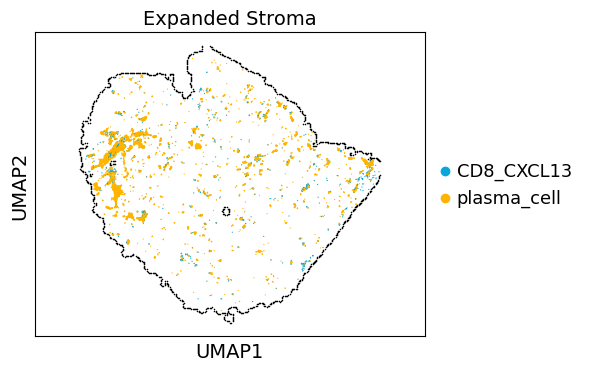

In [20]:
df = adata9[adata9.obs['anno2'].isin(['CD8_CXCL13','plasma_cell'])]

fig,ax = plt.subplots(figsize=(5, 4))
plt.grid(False)
tissue_outline=pd.DataFrame(adata9.uns['tissue_outline'],columns=['x','y'])
plt.axis('equal')
sns.scatterplot(data=tissue_outline,x='x',y='y',color='black',s=1,edgecolor=None,ax = ax)
sc.pl.umap(df,color=['anno2'],
           groups=['CD8_CXCL13','plasma_cell'],
               palette={
        'CD8_CXCL13': '#0AA6D8',
        'plasma_cell': '#FFB500'
    },
           s=3,ax = ax,show = False)
# 恢复原来的坐标范围，保证 outline 的比例不变
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.axis('equal')
plt.title('Expanded Stroma')
plt.savefig('figure6I2.png',dpi = 900)
plt.show()

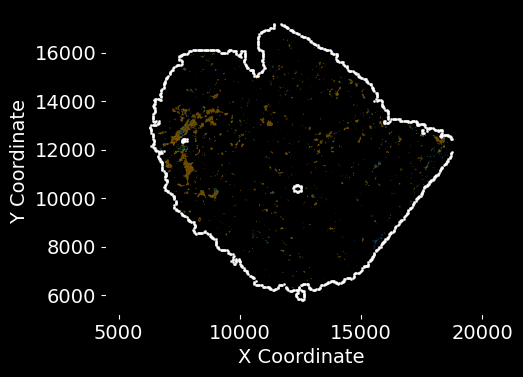

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from scipy.interpolate import splprep, splev
import seaborn as sns

# 1. 处理 cell_border 数组，展开为 DataFrame
array_2d = adata9.obsm['cell_border'].reshape(-1, adata9.obsm['cell_border'].shape[-1])
df = pd.DataFrame(array_2d)
df['cellID'] = df.index // 32
df['cellID'] = df['cellID'].astype(int)
df.rename(columns={0: 'x', 1: 'y'}, inplace=True)

# 2. 去除无效边界点
df_filtered = df[(df['x'] != 32767) & (df['y'] != 32767)]

# 3. 合并原始位置信息（对merge出来的x/y_x,y_x是否合并请自己确认，通常空间数据可能要加或者只取一个）
df_filtered = pd.merge(df_filtered, adata9.obs[['x', 'y', 'cellID']], on='cellID', how='left')
df_filtered['x'] = df_filtered['x_x'] + df_filtered['x_y']
df_filtered['y'] = df_filtered['y_x'] + df_filtered['y_y']
df_cellborder = df_filtered[['cellID', 'x', 'y']]

# 4. 只保留感兴趣的细胞
cell_list = adata9.obs['cellID'].astype(int).tolist()
df_cellborder = df_cellborder[df_cellborder['cellID'].isin(cell_list)]

# 5. 不同类型的cellID分组
plasma_list = adata9.obs[adata9.obs['anno2'] == 'plasma_cell']['cellID'].astype(int).tolist()
CD8_CXCL13_list = adata9.obs[adata9.obs['anno2'] == 'CD8_CXCL13']['cellID'].astype(int).tolist()

# 6. 构建每一类的cell边界df
plasma_cell_border = df_cellborder[df_cellborder['cellID'].isin(plasma_list)]
CD8_CXCL13_cell_border = df_cellborder[df_cellborder['cellID'].isin(CD8_CXCL13_list)]
# 7. 每个细胞的边界取出为数组list
def border_list_from_df(cell_border_df):
    return [np.array(group[['x', 'y']].values) for _, group in cell_border_df.groupby('cellID') if len(group) >= 3]

filtered_cell_borders_list1 = border_list_from_df(plasma_cell_border)
filtered_cell_borders_list2 = border_list_from_df(CD8_CXCL13_cell_border)

# 8. 配色和背景
plasma_color = '#FFB500'
CD8_color = '#0AA6D8'
BG_COLOR = 'black'
TXT_COLOR = 'white'

fig, ax = plt.subplots(figsize=(5, 4))
fig.patch.set_facecolor(BG_COLOR)
ax.set_facecolor(BG_COLOR)

# 9. 边界 & 生成Path
def smooth_boundary(boundary, smoothness=0.5):
    x = boundary[:, 0]
    y = boundary[:, 1]
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    tck, u = splprep([x, y], s=smoothness * len(x), per=True)
    u_new = np.linspace(u.min(), u.max(), 100)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))

patches = []
for cell_boundary in filtered_cell_borders_list1:
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             facecolor=plasma_color,
                             lw=0.05,
                             antialiased=True))
for cell_boundary in filtered_cell_borders_list2:
    smooth = smooth_boundary(cell_boundary, 0.8)
    codes = [Path.LINETO] * len(smooth)
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY
    patches.append(PathPatch(Path(smooth, codes),
                             facecolor=CD8_color,
                             lw=0.05,
                             antialiased=True))

ax.add_collection(PatchCollection(patches, match_original=True))

# 10. 绘制组织轮廓
sns.scatterplot(data=tissue_outline, x='x', y='y',
                color='white', s=3, edgecolor=None, ax=ax)

# 11. 美化和保存
ax.set_xlabel("X Coordinate", color=TXT_COLOR)
ax.set_ylabel("Y Coordinate", color=TXT_COLOR)
ax.tick_params(axis='both', colors=TXT_COLOR)
ax.grid(False)
plt.axis('equal')

plt.savefig('fig6I2_zoomin.png',
            dpi=2500,
            bbox_inches='tight',
            facecolor=BG_COLOR,
            edgecolor='none')

plt.show()

# fig6J

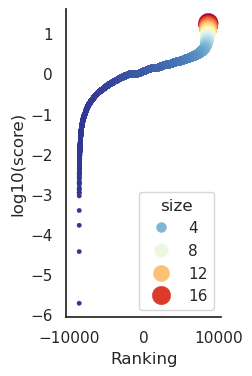

In [16]:
mport scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ====== STEP 1: Integrate maximal clone size into obs, cleanup ======
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')
df = pd.read_csv('./bin50.Bcellclonesize.tsv')
original_index = adata.obs.index

# Merge clone size
tmp = adata.obs.merge(df[['loc', 'n_cells']], on='loc', how='left')
tmp['n_cells'] = tmp['n_cells'].fillna(0)
tmp.index = original_index  # restore index order
adata.obs = tmp
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']
if 'T_clone_expansion_n_cells' in adata.obs.columns:
    del adata.obs['T_clone_expansion_n_cells']

# ====== STEP 2: Subset to D06053D2, stroma region, and build expansion label ======
D06053D2 = adata[adata.obs.batch == 'D06053D2'].copy()
region_list = ['Stroma', 'LA-PCA', 'LA-TLS', 'LA-myloid-aggregate']
D06053D2_stroma = D06053D2[D06053D2.obs['annotation'].isin(region_list)].copy()
D06053D2_stroma.obs['Bcellexpansion'] = 'no'
D06053D2_stroma.obs.loc[
    D06053D2_stroma.obs['B_clone_expansion_n_cells'] >= 2,
    'Bcellexpansion'
] = 'yes'

# ====== STEP 3: Normalize, log-transform and run differential expression ======
sc.pp.normalize_total(D06053D2_stroma, target_sum=1e4)
sc.pp.log1p(D06053D2_stroma)
sc.tl.rank_genes_groups(
    D06053D2_stroma,
    groupby='Bcellexpansion',
    method='t-test',
    use_raw=False,
    key_added='rank_yes_vs_no'
)

# ====== STEP 4: Process ranked genes and visualize bubble plot ======
sns.set_theme(style="white")

# Read DE result for group 'no' (expanded vs not)
result = sc.get.rank_genes_groups_df(
    D06053D2_stroma,
    group='no',
    key='rank_yes_vs_no'
)

# Keep only positive scores, log-transform scores for y axis
result = result[result['scores'] > 0].copy()
result['log10_score'] = np.log10(result['scores'])
result['size'] = result['scores']

# Build symmetrical ranking for bubble plot (centered at 0)
result['ranking'] = np.arange(1, len(result) + 1)
result['ranking'] = len(result) / 2 - result['ranking']

# ====== STEP 5: Bubble plot ======
plt.figure(figsize=(2, 4))
sns.scatterplot(
    data=result,
    x='ranking',
    y='log10_score',
    size='size',
    hue='size',
    palette='RdYlBu_r',
    edgecolor=None,
    sizes=(10, 200)
)
plt.xlim(-max(abs(result['ranking'])) * 1.2, max(abs(result['ranking'])) * 1.2)
plt.xlabel('Ranking')
plt.ylabel('log10(score)')
sns.despine()
plt.savefig('fig6J.pdf', dpi=600, bbox_inches='tight')
plt.show()

# fig6G

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


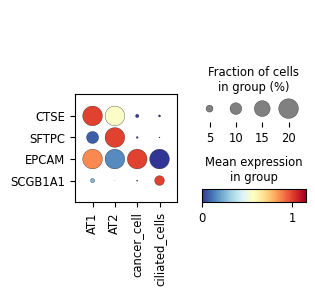

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


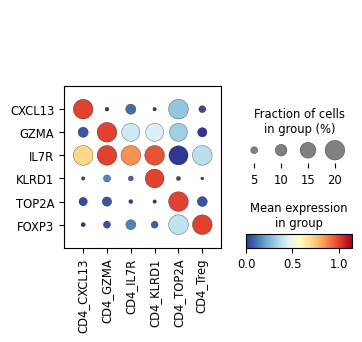

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


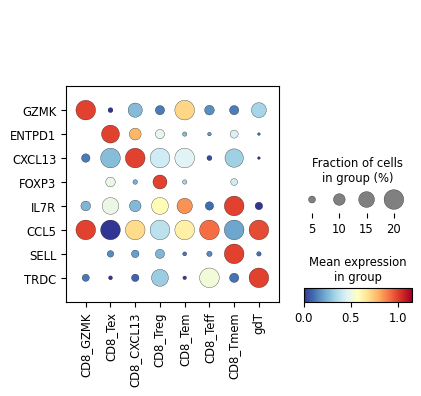

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


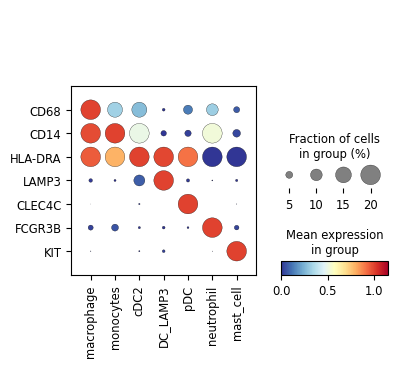

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


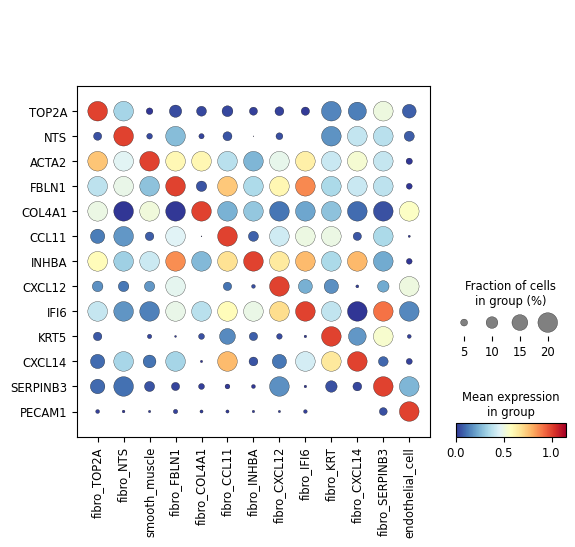

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


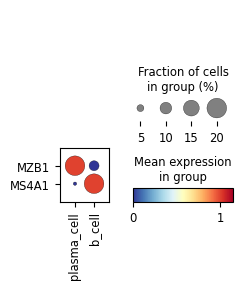

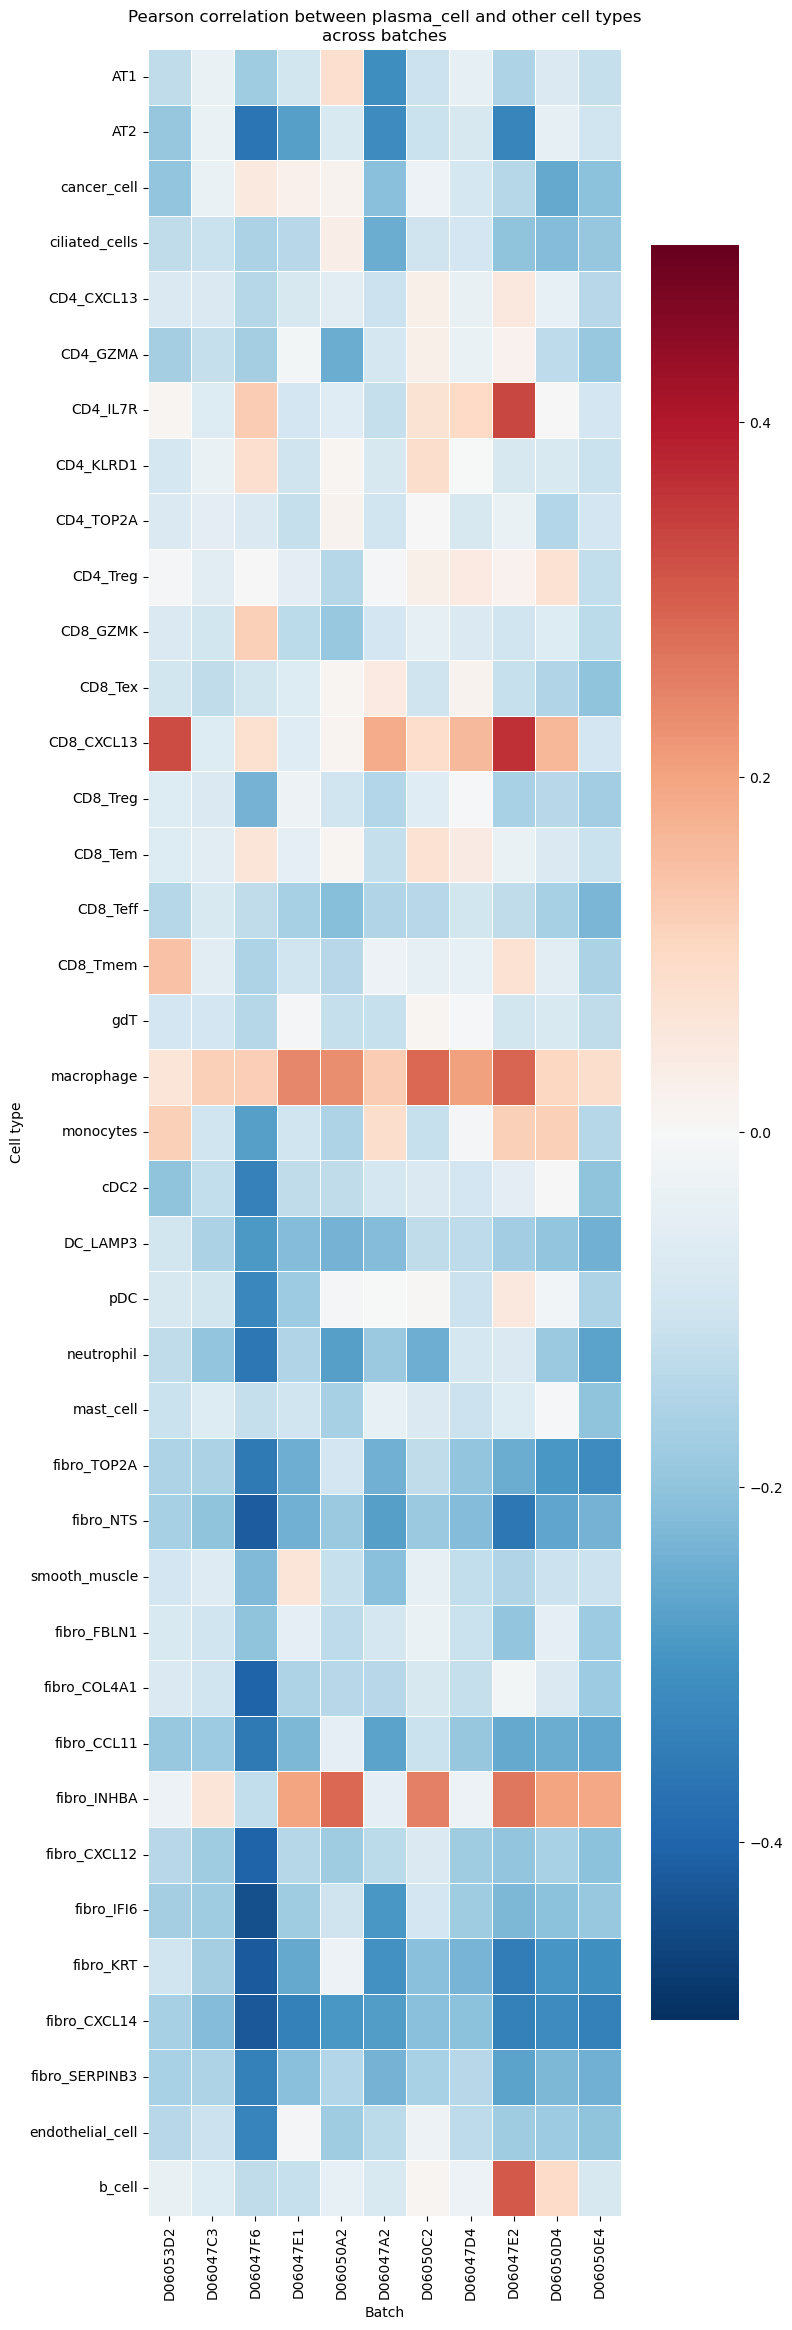

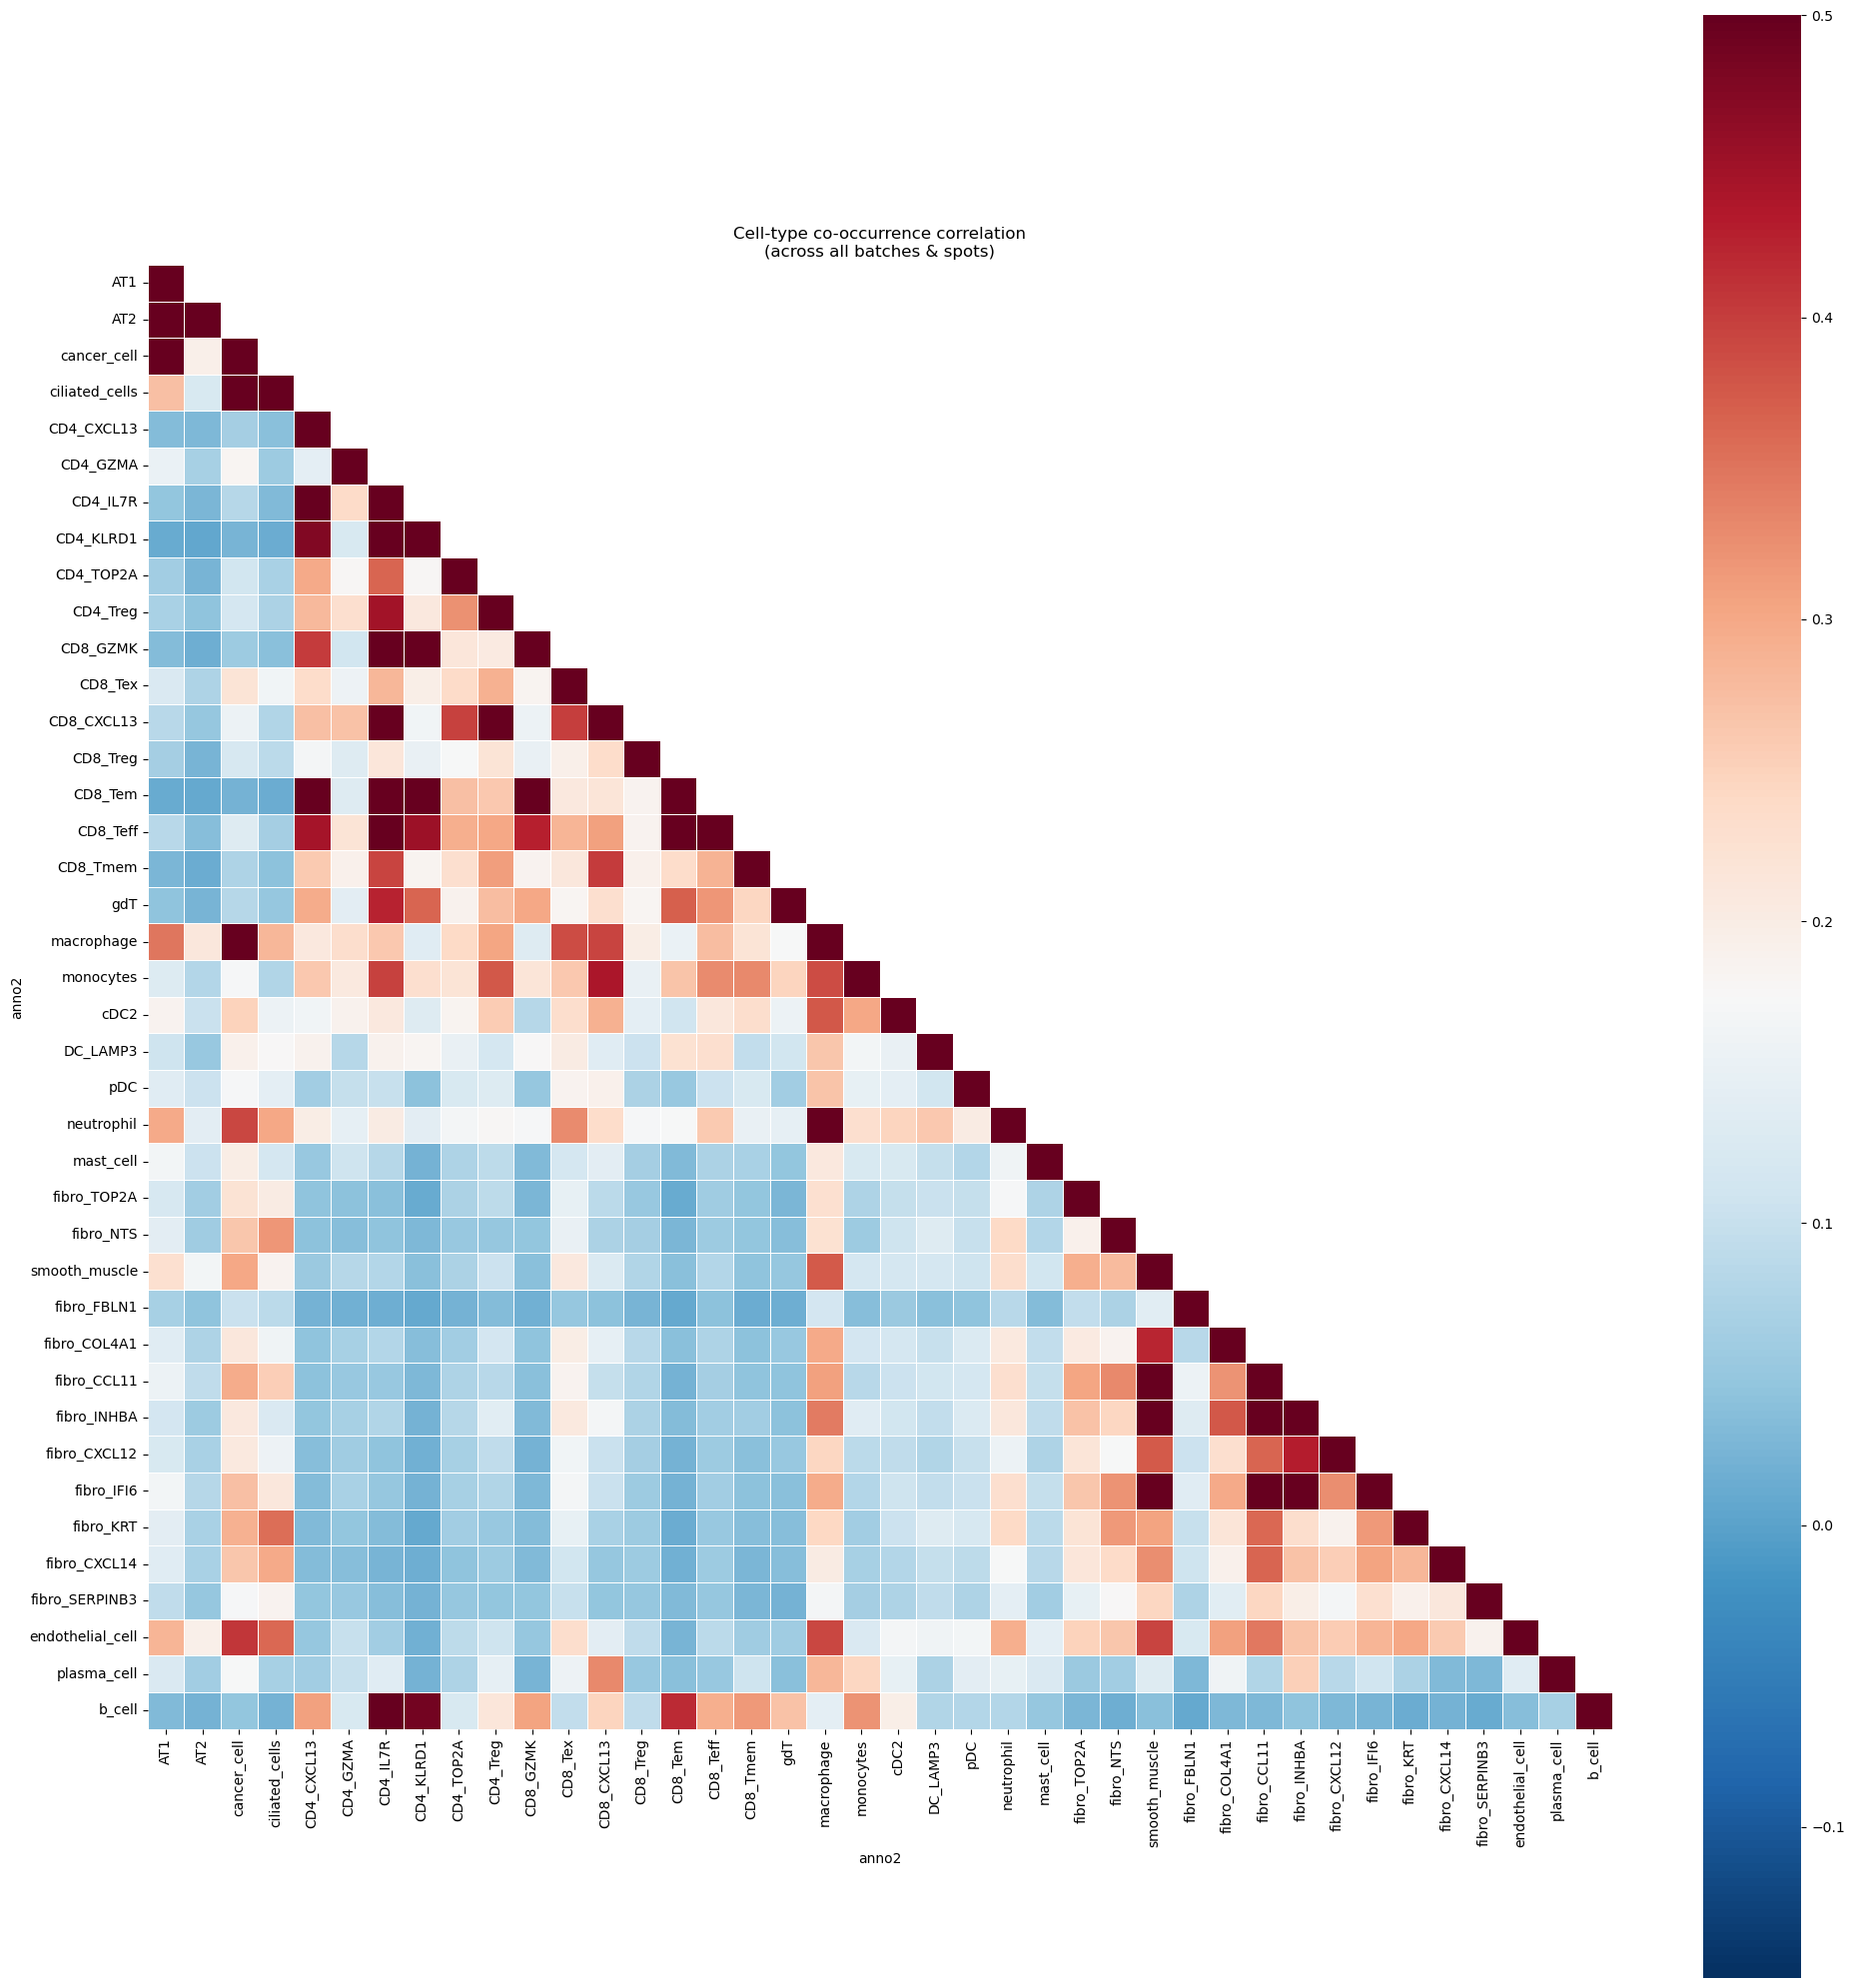

In [28]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# ======== Dotplot Section: LUAD scRNA-seq cell type markers - Figure 6G1-G6 =========
rna = sc.read_h5ad('/data1/fengyu/methods/scRNA/LUAD_GSE148071/luad_forcellbin.h5ad')
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)

# --- Dotplot G1 (epithelial/cancer/ciliated) ---
sc.pl.dotplot(
    rna[rna.obs.anno.isin(['epi','cancer_cell','ciliated_cells'])],
    var_names=['CTSE', 'SFTPC', 'EPCAM', 'SCGB1A1'],
    groupby='anno2',
    standard_scale='var',
    swap_axes=True,
    dot_max=0.2,
    cmap='RdYlBu_r',
    vmax=1.15,
    save='fig6G1.pdf'
)

# --- Dotplot G2 (CD4 subtypes) ---
order_g2 = ['CD4_CXCL13','CD4_GZMA','CD4_IL7R','CD4_KLRD1','CD4_TOP2A','CD4_Treg']
sc.pl.dotplot(
    rna[rna.obs.anno2.isin(order_g2)],
    var_names=['CXCL13', 'GZMA', 'IL7R', 'KLRD1', 'TOP2A', 'FOXP3'],
    groupby='anno2',
    standard_scale='var',
    cmap='RdYlBu_r',
    dot_max=0.2,
    vmax=1.15,
    swap_axes=True,
    categories_order=order_g2,
    save='fig6G2.pdf'
)

# --- Dotplot G3 (CD8/gdT) ---
order_g3 = ['CD8_GZMK','CD8_Tex','CD8_CXCL13','CD8_Treg', 'CD8_Tem','CD8_Teff','CD8_Tmem','gdT']
sc.pl.dotplot(
    rna[rna.obs.anno2.isin(order_g3)],
    var_names=['GZMK','ENTPD1','CXCL13','FOXP3','IL7R','CCL5','SELL','TRDC'],
    groupby='anno2',
    standard_scale='var',
    cmap='RdYlBu_r',
    dot_max=0.2,
    vmax=1.15,
    swap_axes=True,
    categories_order=order_g3,
    save='fig6G3.pdf'
)

# --- Dotplot G4 (myeloid) ---
order_g4 = ['macrophage', 'monocytes', 'cDC2', 'DC_LAMP3', 'pDC',  'neutrophil','mast_cell']
sc.pl.dotplot(
    rna[rna.obs.anno2.isin(order_g4)],
    var_names=['CD68','CD14','HLA-DRA','LAMP3','CLEC4C','FCGR3B','KIT'],
    groupby='anno2',
    standard_scale='var',
    cmap='RdYlBu_r',
    dot_max=0.2,
    vmax=1.15,
    swap_axes=True,
    categories_order=order_g4,
    save='fig6G4.pdf'
)

# --- Dotplot G5 (fibroblast/endothelial) ---
order_g5 = [
    'fibro_TOP2A', 'fibro_NTS', 'smooth_muscle', 'fibro_FBLN1','fibro_COL4A1',
    'fibro_CCL11','fibro_INHBA','fibro_CXCL12', 'fibro_IFI6', 'fibro_KRT',
    'fibro_CXCL14','fibro_SERPINB3','endothelial_cell'
]
sc.pl.dotplot(
    rna[rna.obs.anno2.isin(order_g5)],
    var_names=['TOP2A','NTS','ACTA2','FBLN1','COL4A1','CCL11','INHBA','CXCL12','IFI6','KRT5','CXCL14','SERPINB3','PECAM1'],
    groupby='anno2',
    standard_scale='var',
    cmap='RdYlBu_r',
    dot_max=0.2,
    vmax=1.15,
    swap_axes=True,
    categories_order=order_g5,
    save='fig6G5.pdf'
)

# --- Dotplot G6 (plasma/b cell) ---
order_g6 = ['plasma_cell','b_cell']
sc.pl.dotplot(
    rna[rna.obs.anno2.isin(order_g6)],
    var_names=['MZB1','MS4A1'],
    groupby='anno2',
    standard_scale='var',
    cmap='RdYlBu_r',
    dot_max=0.2,
    vmax=1.15,
    swap_axes=True,
    categories_order=order_g6,
    save='fig6G6.pdf'
)

# ======== Figure 6H: Cell-type co-occurrence heatmap (per-batch spatial bins) ========
cell = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')
tmp = cell[:, ['IGHG1','IGHG3','IGHG4']].to_df()
tmp['IgG'] = tmp.sum(axis=1)
df = cell.obs
df['IgG'] = tmp['IgG']

bs = 200
df['bin200_x'] = df['x'] // bs * bs
df['bin200_y'] = df['y'] // bs * bs
df['loc'] = df['batch'].astype(str) + '_' + df['bin200_x'].astype(str) + '_' + df['bin200_y'].astype(str)
df['anno2'] = df['anno2'].astype(str)
df = df[df['anno'].notna()]
df = df[df['anno'] != 'nan']

target = 'plasma_cell'

# -- Pearson correlation batchwise (plasma_cell vs others), wide-form counts per bin for each batch --
def corr_in_batch(sub_df):
    wide = (
        sub_df.groupby(['loc', 'anno2'])
              .size()
              .unstack(fill_value=0)
    )
    if target not in wide.columns:
        return pd.Series(dtype=float)
    res = {}
    for ct in wide.columns:
        if ct == target:
            continue
        # Only use locations where either cell type is present to avoid noise
        mask = (wide[target] + wide[ct]) > 0
        x = wide.loc[mask, target]
        y = wide.loc[mask, ct]
        if len(x) >= 3:
            r, _ = pearsonr(x, y)
            res[ct] = r
        else:
            res[ct] = np.nan
    return pd.Series(res)

corr_tbl = df.groupby('batch').apply(corr_in_batch).T

batch_order = [
    'D06053D2', 'D06047C3', 'D06047F6', 'D06047E1', 'D06050A2',
    'D06047A2', 'D06050C2', 'D06047D4', 'D06047E2', 'D06050D4',
    'D06050E4'
]
corr_tbl = corr_tbl[batch_order]

celltype_order = [
    'AT1','AT2','cancer_cell','ciliated_cells',
    'CD4_CXCL13','CD4_GZMA','CD4_IL7R','CD4_KLRD1','CD4_TOP2A','CD4_Treg',
    'CD8_GZMK','CD8_Tex','CD8_CXCL13','CD8_Treg','CD8_Tem','CD8_Teff','CD8_Tmem','gdT',
    'macrophage','monocytes','cDC2','DC_LAMP3','pDC','neutrophil','mast_cell',
    'fibro_TOP2A','fibro_NTS','smooth_muscle','fibro_FBLN1','fibro_COL4A1',
    'fibro_CCL11','fibro_INHBA','fibro_CXCL12','fibro_IFI6','fibro_KRT',
    'fibro_CXCL14','fibro_SERPINB3','endothelial_cell','plasma_cell','b_cell'
]
corr_tbl = corr_tbl.reindex([ct for ct in celltype_order if ct in corr_tbl.index])

plt.figure(figsize=(max(8, corr_tbl.shape[1]*0.6), max(6, corr_tbl.shape[0]*0.6)))
sns.heatmap(
    corr_tbl,
    annot=False,
    fmt='.2f',
    cmap='RdBu_r',
    vmin=-0.5, vmax=0.5,
    linewidths=.5
)
plt.title('Pearson correlation between plasma_cell and other cell types\nacross batches')
plt.xlabel('Batch')
plt.ylabel('Cell type')
plt.tight_layout()
plt.grid(False)
plt.savefig('fig6H.pdf')
plt.show()

# ======== Figure 6G: Global cell-type co-occurrence heatmap (all batches) ========
wide = (
    df.groupby(['batch', 'loc', 'anno2'])
      .size()
      .unstack(fill_value=0)
)
corr_mat = wide.corr(method='pearson')

present_categories = [c for c in celltype_order if c in corr_mat.columns]
corr_mat = corr_mat.loc[present_categories, present_categories]

mask = np.triu(np.ones_like(corr_mat, dtype=bool), k=1)

plt.figure(figsize=(max(8, len(present_categories)*0.5), max(7, len(present_categories)*0.5)))
sns.heatmap(
    corr_mat,
    mask=mask,
    annot=False,
    fmt='.2f',
    cmap='RdBu_r',
    vmin=-0.15, vmax=0.5,
    linewidths=.5,
    square=True
)
plt.title('Cell-type co-occurrence correlation\n(across all batches & spots)')
plt.tight_layout()
plt.grid(False)
plt.show()

# fig6K

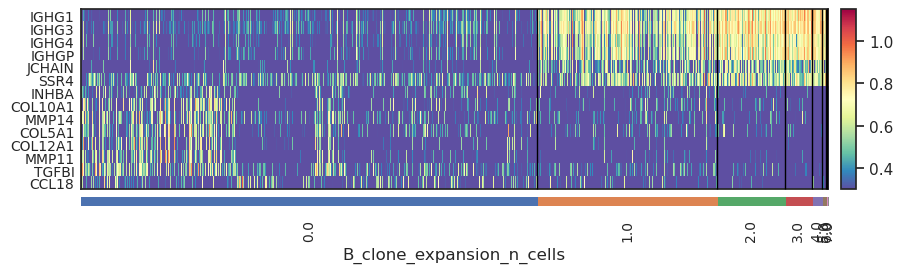

In [19]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# ---- STEP 1: Integrate maximal clone size ----
adata = sc.read_h5ad('/data1/fengyu/methods/fig8/allLUAD_bin50.h5ad')
df = pd.read_csv('./bin50.Bcellclonesize.tsv')
original_index = adata.obs.index

tmp = adata.obs.merge(df[['loc', 'n_cells']], on='loc', how='left')
tmp['n_cells'] = tmp['n_cells'].fillna(0)
tmp.index = original_index
adata.obs = tmp
adata.obs['B_clone_expansion_n_cells'] = adata.obs['n_cells']
del adata.obs['n_cells']
if 'T_clone_expansion_n_cells' in adata.obs.columns:
    del adata.obs['T_clone_expansion_n_cells']

# ---- STEP 2: Subset & annotate for stroma in D06053D2 ----
sample = 'D06053D2'
region_list = ['Stroma','LA-PCA','LA-TLS','LA-myloid-aggregate']
D06053D2 = adata[adata.obs.batch == sample].copy()
D06053D2_stroma = D06053D2[D06053D2.obs['annotation'].isin(region_list)].copy()
D06053D2_stroma.obs['Bcellexpansion'] = 'no'
D06053D2_stroma.obs.loc[D06053D2_stroma.obs['B_clone_expansion_n_cells'] >= 2, 'Bcellexpansion'] = 'yes'

# ---- STEP 3: Normalize, log transform, DE (optional, does not affect plotting) ----
sc.pp.normalize_total(D06053D2_stroma, target_sum=1e4)
sc.pp.log1p(D06053D2_stroma)
sc.tl.rank_genes_groups(
    D06053D2_stroma,
    groupby='Bcellexpansion',
    method='t-test',
    use_raw=False,
    key_added='rank_yes_vs_no'
)

# ---- STEP 4: Heatmap plotting ----
# Group by clone size class as string (for figure; uses string for clear group labels)
D06053D2_stroma.obs['B_clone_expansion_n_cells'] = D06053D2_stroma.obs['B_clone_expansion_n_cells'].astype(str)

# Select marker genes (edit as needed for your figure)
markers = [
    'IGHG1','IGHG3','IGHG4','IGHGP','JCHAIN','SSR4','INHBA','COL10A1',
    'MMP14','COL5A1','COL12A1','MMP11','TGFBI','CCL18'
]

sc.pl.heatmap(
    D06053D2_stroma,
    markers,
    groupby='B_clone_expansion_n_cells',
    use_raw=False,
    swap_axes=True,
    standard_scale='var',
    cmap='Spectral_r',
    vmax=1.15,
    vmin=0.3,
    show=False
)
plt.savefig('fig6K.pdf', dpi=600)
plt.show()

# fig6M

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import scvelo as scv
import anndata as ad
#import omicverse as ov
#import pcurvepy2        

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LUAD=sc.read_h5ad('/data1/fengyu/methods/validation/GSE207422.h5ad')
LUAD.var["mt"] = LUAD.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    LUAD, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pp.normalize_total(LUAD, target_sum=1e4)
sc.pp.log1p(LUAD)
sc.pp.highly_variable_genes(LUAD, min_mean=0.0125, max_mean=3, min_disp=0.5)
LUAD.raw = LUAD.copy()
sc.pp.scale(LUAD, max_value=10)
sc.tl.pca(LUAD, svd_solver="arpack")
sc.pp.neighbors(LUAD, n_neighbors=10, n_pcs=40)
sc.tl.umap(LUAD)
sc.tl.leiden(
    LUAD,
    resolution=0.9,
    random_state=0,
    n_iterations=2,
    directed=False,
)

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


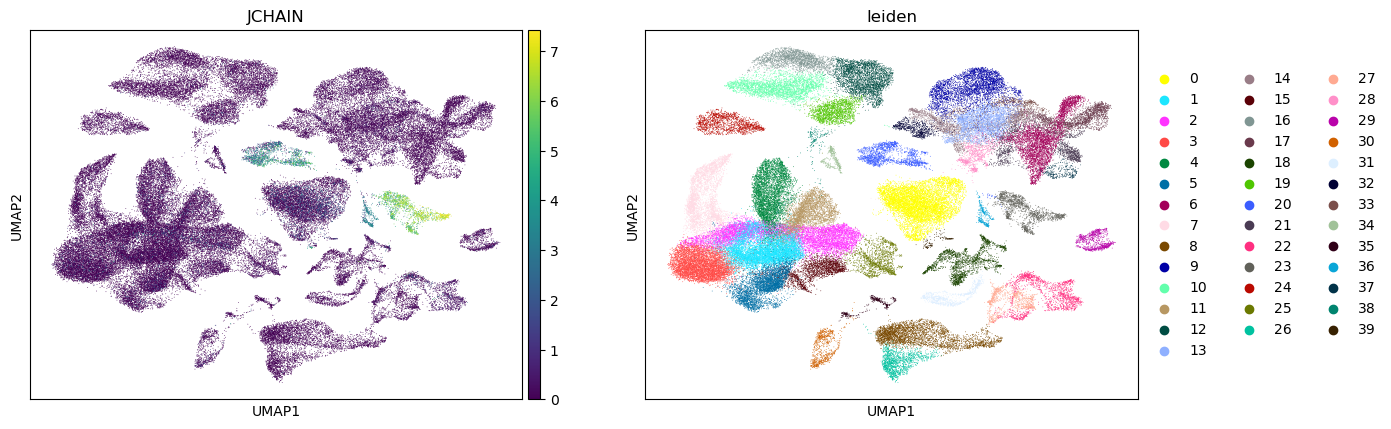

In [3]:
sc.pl.umap(LUAD, color=["JCHAIN", "leiden"])

/tmp/ipykernel_204154/233944427.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  fibro.obs['group']=fibro.obs['Resource'].astype(str)+'_'+fibro.obs['RECIST'].astype(str)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


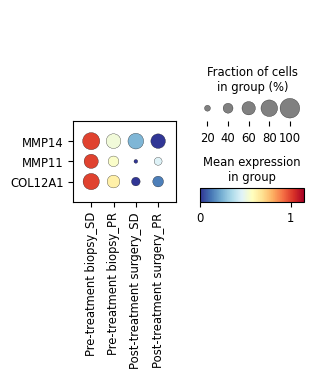

In [4]:
genes=['MMP14','MMP11','COL12A1']
order=['Pre-treatment biopsy_SD','Pre-treatment biopsy_PR','Post-treatment surgery_SD','Post-treatment surgery_PR' ]
fibro=LUAD[LUAD.obs['leiden'].isin(['30','35'])]
fibro.obs['group']=fibro.obs['Resource'].astype(str)+'_'+fibro.obs['RECIST'].astype(str)
sc.pl.dotplot(fibro,genes,standard_scale='var',vmax=1.15,
              groupby='group',swap_axes=True,cmap='RdYlBu_r',categories_order=order,dot_max = 1,save='fig6m_left.pdf')

/tmp/ipykernel_204154/534191070.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  plasmacell.obs['group']=plasmacell.obs['Resource'].astype(str)+'_'+plasmacell.obs['RECIST'].astype(str)


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


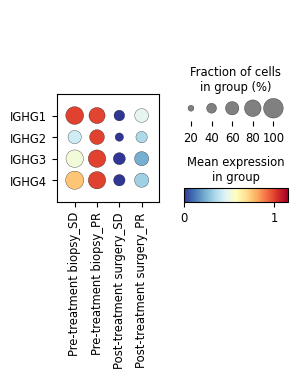

In [6]:
plasmacell=LUAD[LUAD.obs['leiden'].isin(['20','23','36','39'])]
plasmacell.obs['group']=plasmacell.obs['Resource'].astype(str)+'_'+plasmacell.obs['RECIST'].astype(str)
sc.pl.dotplot(plasmacell,['IGHG1','IGHG2','IGHG3','IGHG4'],standard_scale='var',
              groupby='group',swap_axes=True,cmap='RdYlBu_r',categories_order=order,vmax=1.15,save='fig6m_middle.pdf')

/tmp/ipykernel_204154/3062561266.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  macrophage.obs['group']=macrophage.obs['Resource'].astype(str)+'_'+macrophage.obs['RECIST'].astype(str)


/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


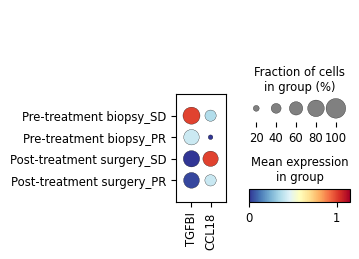

In [8]:
genes=['TGFBI','CCL18']
order=['Pre-treatment biopsy_SD','Pre-treatment biopsy_PR','Post-treatment surgery_SD','Post-treatment surgery_PR' ]
macrophage=LUAD[LUAD.obs['leiden'].isin(['6','9','13','15','17','21','28','32','33','37'])]
macrophage.obs['group']=macrophage.obs['Resource'].astype(str)+'_'+macrophage.obs['RECIST'].astype(str)
sc.pl.dotplot(macrophage,genes,standard_scale='var',vmax=1.15,dot_max = 1,
              groupby='group',cmap='RdYlBu_r',categories_order=order,save='fig6m_right.pdf')